In [66]:
from sparse_image_warp import sparse_image_warp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.optim.lr_scheduler import StepLR
from utils.visualisations import show_images

from utils.get_data import get_dataloader_augmented
current_path = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
current_path = os.getcwd()
train_loader,valid_loader,test_loader = get_dataloader_augmented(f'{current_path}/data/avmnist', type="burst_noise", batch_size=128, num_workers=0)

Batch of images | image: torch.Size([128, 1, 28, 28]) | audio: torch.Size([128, 1, 112, 112]) | label: torch.Size([128])


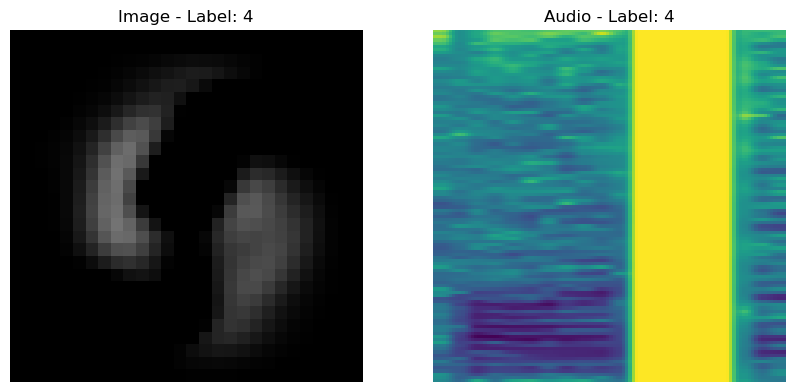

In [68]:
for image, audio, label in train_loader:
    print(f"Batch of images | image: {image.shape} | audio: {audio.shape} | label: {label.shape}")
    idx = 1
    show_images(image[idx], audio[idx], label[idx])
    break  # Test one batch

Original Spectrogram Shape: torch.Size([1, 112, 112])
Warped Spectrogram Shape: torch.Size([1, 112, 112])


C:\Users\Ward\AppData\Local\Temp\Mxt250\mx86_64b\var\log\xwin\ipykernel_25612\3694228941.py:15: UserWarning: The input to TimeStretch must be complex type. Providing non-complex tensor produces invalid results.
  stretched_spec = self.time_stretch(spec, self.stretch_factor)


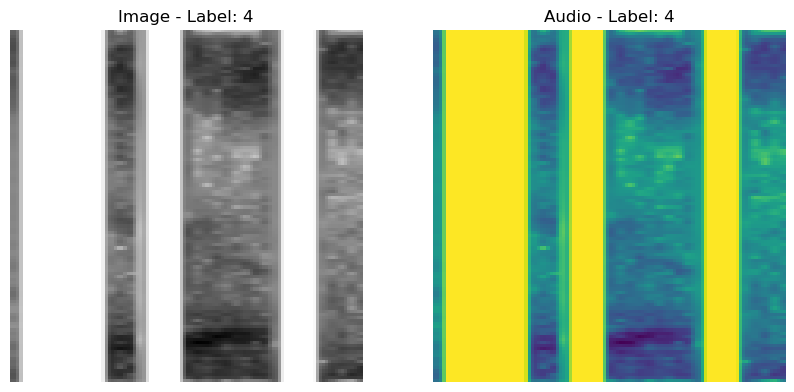

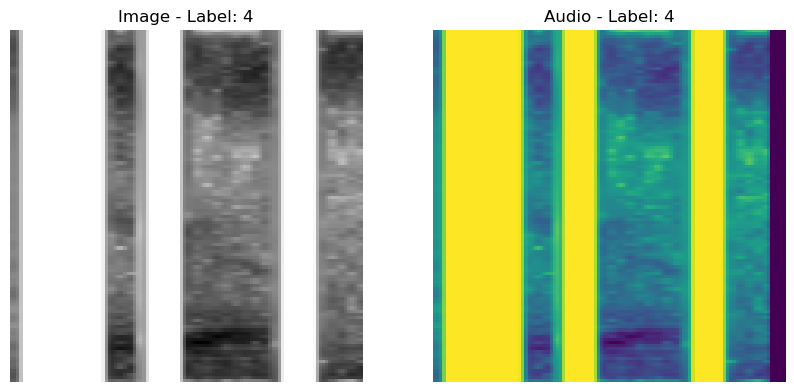

In [69]:
import torch
import torchaudio
import random

class TimeWarpWithStretch(torch.nn.Module):
    def __init__(self, stretch_factor: float, target_length: int):
        super(TimeWarpWithStretch, self).__init__()
        # TimeStretch is used to apply time-stretching to the spectrogram
        self.time_stretch = torchaudio.transforms.TimeStretch(n_freq=112)  # 112 is the number of frequency bins
        self.stretch_factor = stretch_factor
        self.target_length = target_length  # target time length to preserve

    def forward(self, spec):
        # Apply time stretching (time warping)
        stretched_spec = self.time_stretch(spec, self.stretch_factor)
        
        # Ensure the spectrogram is the same size as the original by padding or trimming
        current_length = stretched_spec.shape[-1]  # Length of the time dimension after stretching
        if current_length > self.target_length:
            # Trim if the length exceeds the target length
            stretched_spec = stretched_spec[..., :self.target_length]
        elif current_length < self.target_length:
            # Pad if the length is less than the target length
            padding = self.target_length - current_length
            stretched_spec = F.pad(stretched_spec, (0, padding), "constant", 0)
        
        return stretched_spec

# Simulate an example spectrogram (torch.Size [1, 112, 112])
spectrogram = audio[5]

# Specify a random stretch factor to simulate time warping (can be negative or positive)
stretch_factor = random.uniform(0.8, 1.2)  # For instance, stretching between 80% to 120% of the original time axis

# Initialize the time warping module
time_warp = TimeWarpWithStretch(stretch_factor, target_length=spectrogram.shape[-1])

# Apply the time warping (stretching)
warped_spectrogram = torch.abs(time_warp(spectrogram))

print("Original Spectrogram Shape:", spectrogram.shape)
print("Warped Spectrogram Shape:", warped_spectrogram.shape)  # Should be (1, 112, 112)
show_images(spectrogram, spectrogram, label[idx])
show_images(spectrogram, warped_spectrogram, label[idx])